In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing all libraries

In [2]:
import os
import pandas as pd
import numpy as np
import pickle
import gc
import six
import sys
import joblib
import keras
from numpy import array
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
sys.modules['sklearn.externals.six'] = six
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Layer
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Convolution1D
from tensorflow.keras.optimizers import Adam, SGD
from keras import Model, Sequential, backend
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from keras.layers import Input

In [3]:
import warnings
warnings.filterwarnings('ignore')

Data Loading

In [4]:
data = pd.read_csv('/content/drive/MyDrive/scada_cyber_attack_detection/Data/UNR-IDD.csv')
data.head()

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
0,of:000000000000000c,Port#:1,132,9181,6311853,238,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
1,of:000000000000000c,Port#:2,187,6304498,15713,171,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
2,of:000000000000000c,Port#:3,235,6311567,8030,58,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
3,of:000000000000000c,Port#:4,59,7878,16439,182,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
4,of:000000000000000a,Port#:1,188,6304547,16497,183,46,0,0,0,...,0,0,True,0,7,489,403,-1,TCP-SYN,Attack


Data Cleaning

In [5]:
data.shape

(37411, 34)

In [6]:
data.describe()

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,Packets Tx Errors,Delta Received Packets,...,Total Load/Rate,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size
count,37411.000000,3.741100e+04,3.741100e+04,37411.000000,37411.000000,37411.0,37411.0,37411.0,37411.0,37411.000000,...,3.741100e+04,3.741100e+04,3.741100e+04,3.741100e+04,3.741100e+04,37411.0,37411.000000,3.741100e+04,3.741100e+04,37411.0
mean,21618.897169,2.647491e+07,2.451212e+07,33626.824009,911.096415,0.0,0.0,0.0,0.0,194.958087,...,1.921455e+04,5.145597e+05,1.921455e+04,5.145597e+05,1.921455e+04,0.0,88.690572,1.008636e+05,1.007444e+05,-1.0
std,65283.170126,3.703044e+07,3.439876e+07,88792.970378,982.113446,0.0,0.0,0.0,0.0,1087.140797,...,1.107441e+05,1.863403e+06,1.107441e+05,1.863403e+06,1.107441e+05,0.0,790.715343,2.350297e+05,2.350284e+05,0.0
min,9.000000,7.860000e+02,5.705000e+03,41.000000,26.000000,0.0,0.0,0.0,0.0,0.000000,...,-1.284277e+06,0.000000e+00,-1.284277e+06,0.000000e+00,-1.284277e+06,0.0,4.000000,8.700000e+01,3.700000e+01,-1.0
25%,329.000000,9.104050e+04,5.775950e+04,347.000000,136.000000,0.0,0.0,0.0,0.0,2.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,5.000000,2.367000e+03,2.272000e+03,-1.0
50%,1170.000000,1.263052e+07,1.262658e+07,1240.000000,259.000000,0.0,0.0,0.0,0.0,4.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,6.000000,7.472000e+03,7.349000e+03,-1.0
75%,3417.000000,3.783230e+07,3.176443e+07,3968.000000,1747.000000,0.0,0.0,0.0,0.0,6.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,8.000000,2.343700e+04,2.322000e+04,-1.0
max,352772.000000,2.715925e+08,2.392430e+08,421598.000000,3317.000000,0.0,0.0,0.0,0.0,15695.000000,...,2.004388e+06,2.606759e+07,2.004388e+06,2.606759e+07,2.004388e+06,0.0,9987.000000,1.012574e+06,1.012439e+06,-1.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37411 entries, 0 to 37410
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Switch ID                      37411 non-null  object
 1   Port Number                    37411 non-null  object
 2   Received Packets               37411 non-null  int64 
 3   Received Bytes                 37411 non-null  int64 
 4   Sent Bytes                     37411 non-null  int64 
 5   Sent Packets                   37411 non-null  int64 
 6   Port alive Duration (S)        37411 non-null  int64 
 7   Packets Rx Dropped             37411 non-null  int64 
 8   Packets Tx Dropped             37411 non-null  int64 
 9   Packets Rx Errors              37411 non-null  int64 
 10  Packets Tx Errors              37411 non-null  int64 
 11  Delta Received Packets         37411 non-null  int64 
 12  Delta Received Bytes           37411 non-null  int64 
 13  D

In [8]:
data.columns

Index(['Switch ID', 'Port Number', 'Received Packets', 'Received Bytes',
       'Sent Bytes', 'Sent Packets', 'Port alive Duration (S)',
       'Packets Rx Dropped', 'Packets Tx Dropped', 'Packets Rx Errors',
       'Packets Tx Errors', 'Delta Received Packets', 'Delta Received Bytes',
       'Delta Sent Bytes', 'Delta Sent Packets',
       'Delta Port alive Duration (S)', 'Delta Packets Rx Dropped',
       ' Delta Packets Tx Dropped', 'Delta Packets Rx Errors',
       'Delta Packets Tx Errors', 'Connection Point', 'Total Load/Rate',
       'Total Load/Latest', 'Unknown Load/Rate', 'Unknown Load/Latest',
       'Latest bytes counter', 'is_valid', 'Table ID', 'Active Flow Entries',
       'Packets Looked Up', 'Packets Matched', 'Max Size', 'Label',
       'Binary Label'],
      dtype='object')

In [9]:
data.isna().sum()

Switch ID                        0
Port Number                      0
Received Packets                 0
Received Bytes                   0
Sent Bytes                       0
Sent Packets                     0
Port alive Duration (S)          0
Packets Rx Dropped               0
Packets Tx Dropped               0
Packets Rx Errors                0
Packets Tx Errors                0
Delta Received Packets           0
Delta Received Bytes             0
Delta Sent Bytes                 0
Delta Sent Packets               0
Delta Port alive Duration (S)    0
Delta Packets Rx Dropped         0
 Delta Packets Tx Dropped        0
Delta Packets Rx Errors          0
Delta Packets Tx Errors          0
Connection Point                 0
Total Load/Rate                  0
Total Load/Latest                0
Unknown Load/Rate                0
Unknown Load/Latest              0
Latest bytes counter             0
is_valid                         0
Table ID                         0
Active Flow Entries 

In [10]:
#dropping unnecessary column
data = data.drop('Switch ID', axis=1)
data.head(2)

,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,Packets Tx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
0,Port#:1,132,9181,6311853,238,46,0,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
1,Port#:2,187,6304498,15713,171,46,0,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack


EDA

<Axes: xlabel='Label', ylabel='count'>

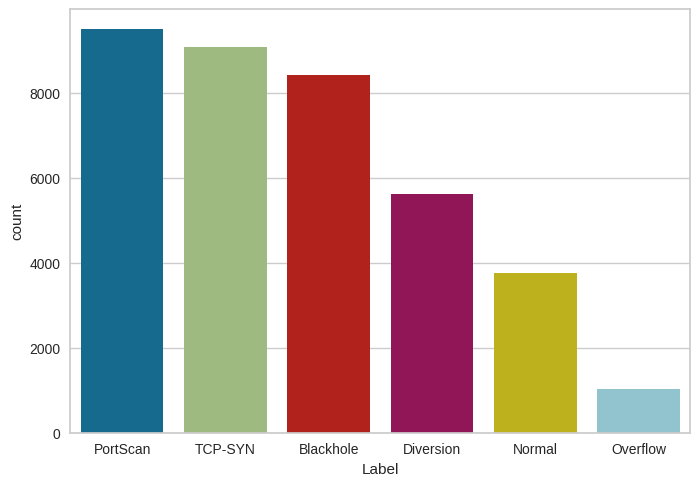

In [11]:
#countplot of target class
temp_df = data['Label'].value_counts().reset_index().rename(columns={'index':'Label','Label':'count'})
sns.barplot(temp_df, x='Label', y='count')

<Axes: ylabel='Received Packets'>

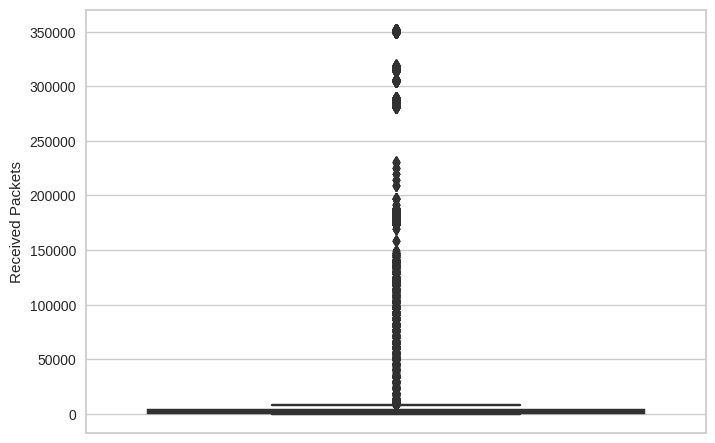

In [12]:
#data distribution plot of received packets column
sns.boxplot(data, y='Received Packets')

<Axes: xlabel='Binary Label', ylabel='count'>

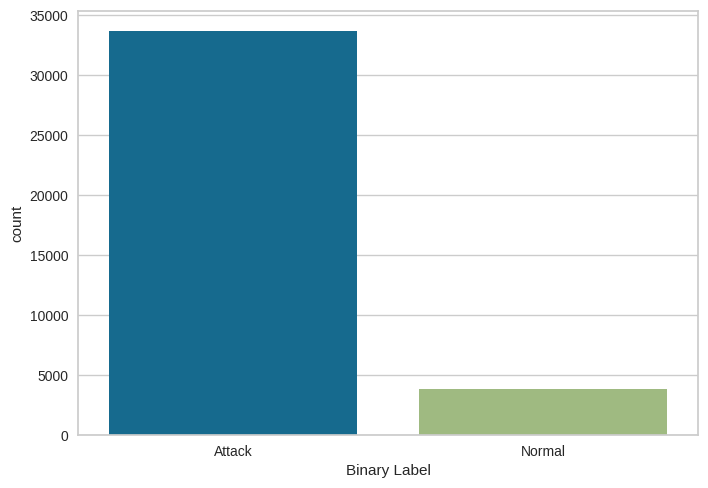

In [13]:
#value count of binary class label
sns.countplot(x=data['Binary Label'])

<Axes: xlabel='Port Number', ylabel='count'>

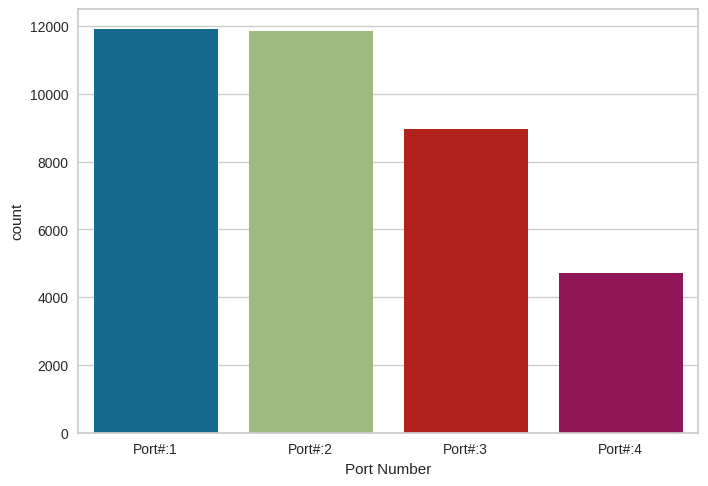

In [14]:
#count plot of port number type column
sns.countplot(x=data['Port Number'])

<Axes: xlabel='Sent Packets'>

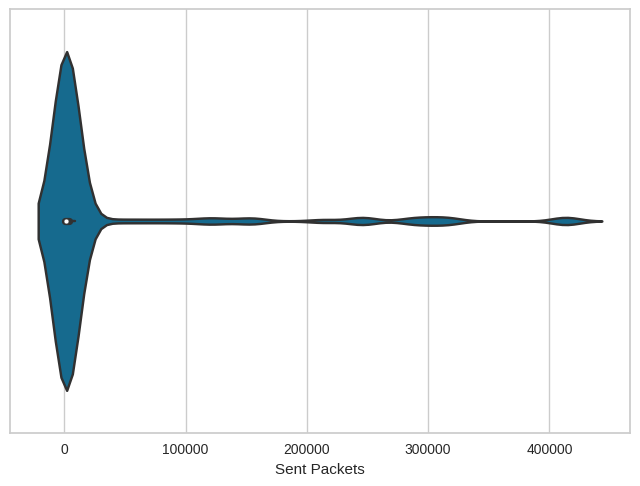

In [15]:
#data distribution of sent packets value
sns.violinplot(data, x='Sent Packets')

Data Preprocessing

In [16]:
data.columns

Index(['Port Number', 'Received Packets', 'Received Bytes', 'Sent Bytes',
       'Sent Packets', 'Port alive Duration (S)', 'Packets Rx Dropped',
       'Packets Tx Dropped', 'Packets Rx Errors', 'Packets Tx Errors',
       'Delta Received Packets', 'Delta Received Bytes', 'Delta Sent Bytes',
       'Delta Sent Packets', 'Delta Port alive Duration (S)',
       'Delta Packets Rx Dropped', ' Delta Packets Tx Dropped',
       'Delta Packets Rx Errors', 'Delta Packets Tx Errors',
       'Connection Point', 'Total Load/Rate', 'Total Load/Latest',
       'Unknown Load/Rate', 'Unknown Load/Latest', 'Latest bytes counter',
       'is_valid', 'Table ID', 'Active Flow Entries', 'Packets Looked Up',
       'Packets Matched', 'Max Size', 'Label', 'Binary Label'],
      dtype='object')

In [17]:
#dropping binary label column because we are working on multiclass
data = data.drop('Binary Label', axis=1)

In [18]:
#splitting data into X and Y
X = data.drop('Label', axis=1)
Y = data.Label

In [19]:
#extracting categorical column name
col = X.select_dtypes(exclude=['float64','int64']).columns.tolist()
col

['Port Number', 'is_valid']

In [20]:
#label encoding(converting categorical data to number)
le = LabelEncoder()
X[col] = X[col].apply(le.fit_transform)
X

,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,Packets Tx Errors,...,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size
0,0,132,9181,6311853,238,46,0,0,0,0,...,0,0,0,0,0,0,9,767,688,-1
1,1,187,6304498,15713,171,46,0,0,0,0,...,0,0,0,0,0,0,9,767,688,-1
2,2,235,6311567,8030,58,46,0,0,0,0,...,0,0,0,0,0,0,9,767,688,-1
3,3,59,7878,16439,182,46,0,0,0,0,...,0,0,0,0,0,0,9,767,688,-1
4,0,188,6304547,16497,183,46,0,0,0,0,...,0,0,0,0,0,0,7,489,403,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37406,1,228,30195,7857046,145141,276,0,0,0,0,...,0,0,0,0,0,0,6,147563,147454,-1
37407,2,1064,18962056,37732,338,276,0,0,0,0,...,0,0,0,0,0,0,6,147563,147454,-1
37408,0,1042,25252012,7856976,145140,276,0,0,0,0,...,0,0,0,0,0,0,8,295511,295404,-1
37409,1,149012,14360115,29509,211,276,0,0,0,0,...,0,0,0,0,0,0,8,295511,295404,-1


In [21]:
from imblearn.over_sampling import SMOTE
#data balancing
oversample = SMOTE()
X, Y = oversample.fit_resample(X,Y)

<Axes: xlabel='Label', ylabel='count'>

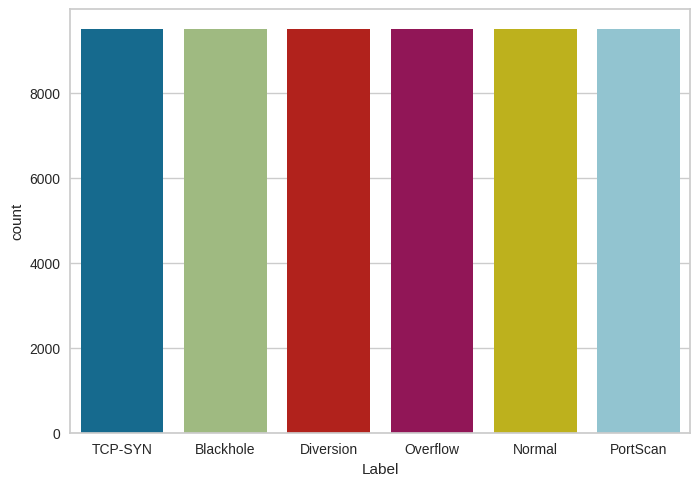

In [22]:
sns.countplot(x=Y)

In [23]:
#target columns categorical values to numbers
y = le.fit_transform(Y)
y

array([5, 5, 5, ..., 5, 5, 5])

<Axes: >

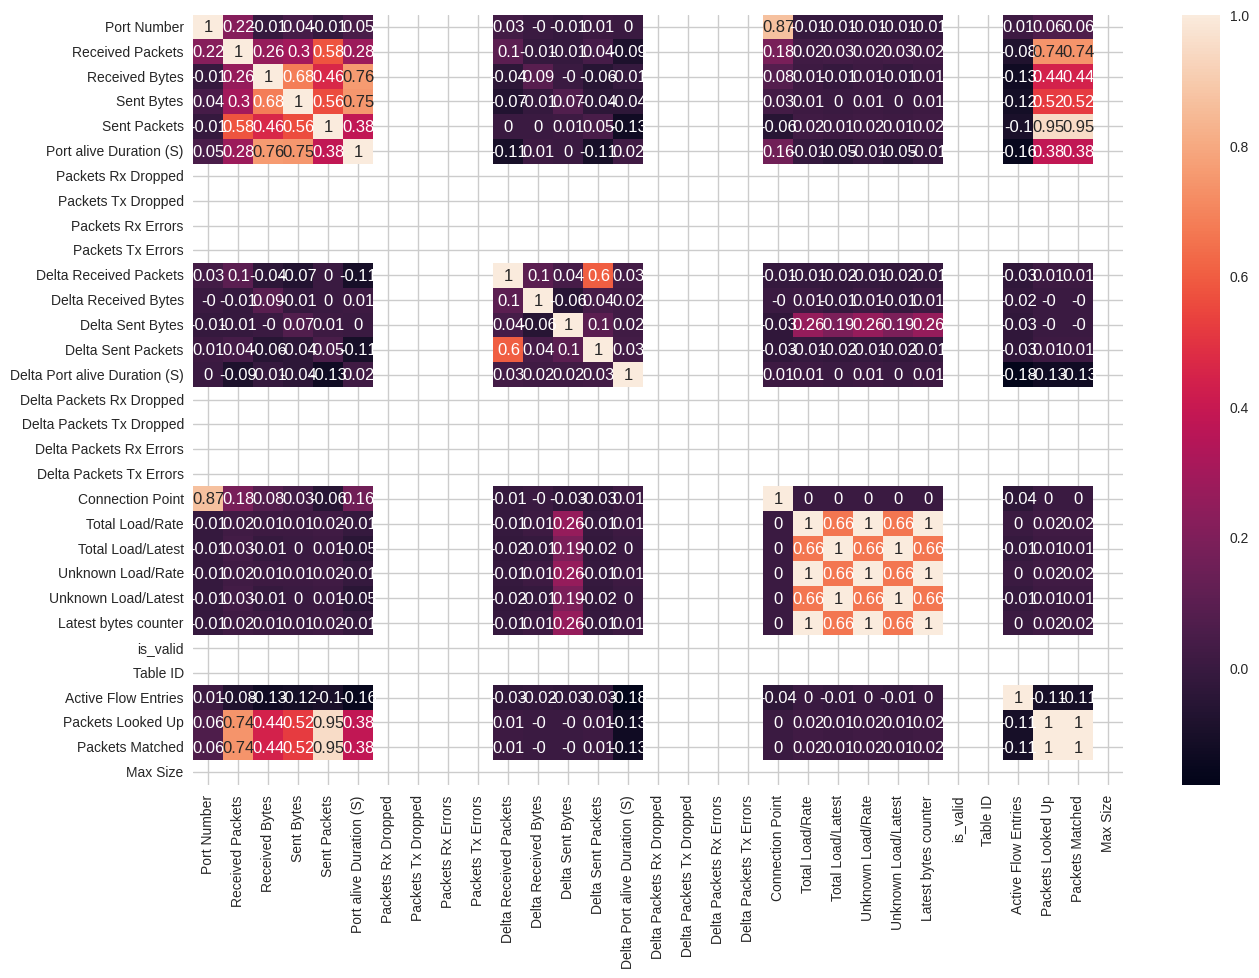

In [24]:
#correlation matrix
correlation = X.corr().round(2)
plt.figure(figsize = (15,10))
sns.heatmap(correlation, annot = True, fmt='g')

Splitting data into train and test

In [25]:
#splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, stratify=y)

# Machine Learning Models

AdaBoost Classifier

In [26]:
adaboost_model = AdaBoostClassifier(n_estimators=4,)
adb = adaboost_model
adb.fit(X_train,y_train)
y_pred = adb.predict(X_test)
acc1 = accuracy_score(y_test,y_pred)

Accuracy Score:  0.647719298245614


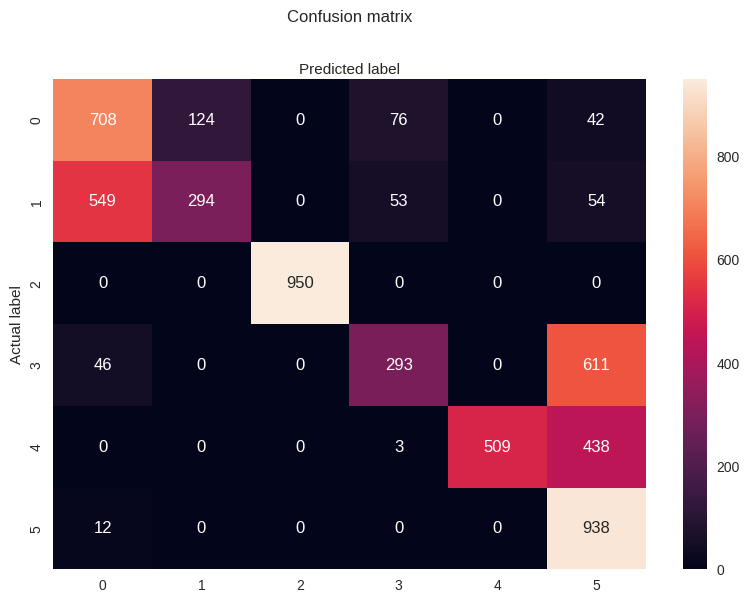

              precision    recall  f1-score   support

           0       0.54      0.75      0.63       950
           1       0.70      0.31      0.43       950
           2       1.00      1.00      1.00       950
           3       0.69      0.31      0.43       950
           4       1.00      0.54      0.70       950
           5       0.45      0.99      0.62       950

    accuracy                           0.65      5700
   macro avg       0.73      0.65      0.63      5700
weighted avg       0.73      0.65      0.63      5700



In [27]:
#accuracy score
print("Accuracy Score: ",accuracy_score(y_test,y_pred))
#confusion Matrix
matrix =confusion_matrix(y_test, y_pred)
class_names=[0,1,2,3,4,5]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix), annot=True, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
#Classification Report
print(classification_report(y_test, y_pred))

XGBoost Classifier

In [28]:
#Xgboost Classifier
xgboost_model = XGBClassifier(max_depth=2, n_estimators=2)
xg = xgboost_model
xg.fit(X_train,y_train)
y_pred = xg.predict(X_test)
acc2 = accuracy_score(y_test,y_pred)

Accuracy Score:  0.6840350877192982


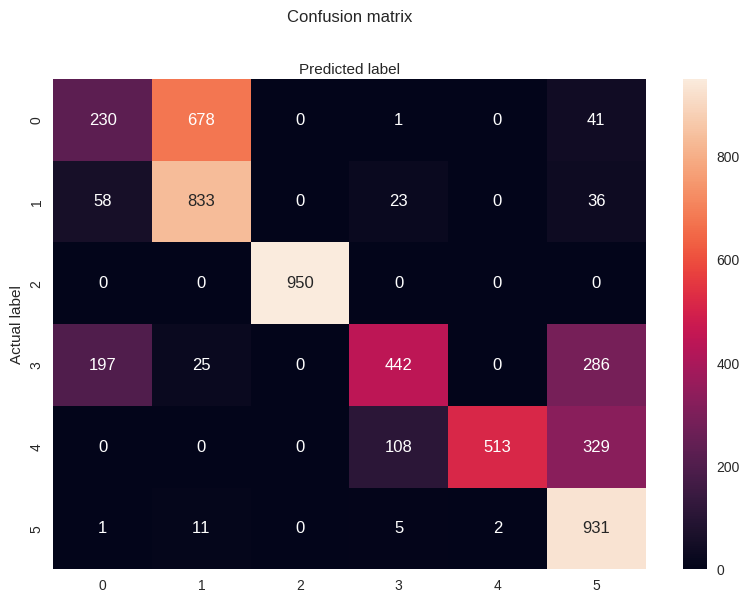

              precision    recall  f1-score   support

           0       0.47      0.24      0.32       950
           1       0.54      0.88      0.67       950
           2       1.00      1.00      1.00       950
           3       0.76      0.47      0.58       950
           4       1.00      0.54      0.70       950
           5       0.57      0.98      0.72       950

    accuracy                           0.68      5700
   macro avg       0.72      0.68      0.66      5700
weighted avg       0.72      0.68      0.66      5700



In [29]:
#accuracy score
print("Accuracy Score: ",accuracy_score(y_test,y_pred))
#confusion Matrix
matrix =confusion_matrix(y_test, y_pred)
class_names=[0,1,2,3,4,5]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix), annot=True, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
#Classification Report
print(classification_report(y_test, y_pred))

# Deep Learning Models

In [30]:
class_labels = LabelBinarizer()
Y = class_labels.fit_transform(Y)
cls = len(class_labels.classes_)
class_labels.classes_

array(['Blackhole', 'Diversion', 'Normal', 'Overflow', 'PortScan',
       'TCP-SYN'], dtype='<U9')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.1, stratify=Y)

In [32]:
y_test_new = np.argmax(y_test,axis=1)

In [33]:
X_train1 = np.expand_dims(X_train,axis=2)
X_test1 = np.expand_dims(X_test,axis=2)

In [34]:
X_test1.shape

(5700, 31, 1)

GRU + LSTM

In [35]:
model=Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train1.shape[1],1)))
model.add(GRU(64, input_shape=(X_train1.shape[1],1)))
model.add(Dense(32))
model.add(Dropout(0.4))
model.add(Dense(cls))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 31, 64)            16896     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
 activation (Activation)     (None, 6)                 0         
                                                                 
Total params: 44134 (172.40 KB)
Trainable params: 44134 

In [36]:
history = model.fit(X_train1,y_train,batch_size=64,epochs=10,verbose=1, validation_data=(X_test1, y_test))

Epoch 1/10
802/802 [==============================] - 16s 8ms/step - loss: 1.1527 - accuracy: 0.4871 - val_loss: 0.8902 - val_accuracy: 0.6221
Epoch 2/10
802/802 [==============================] - 6s 8ms/step - loss: 0.8456 - accuracy: 0.6378 - val_loss: 0.8076 - val_accuracy: 0.6442
Epoch 3/10
802/802 [==============================] - 5s 7ms/step - loss: 0.7216 - accuracy: 0.6936 - val_loss: 0.6652 - val_accuracy: 0.6916
Epoch 4/10
802/802 [==============================] - 7s 8ms/step - loss: 0.6857 - accuracy: 0.7078 - val_loss: 0.6454 - val_accuracy: 0.7151
Epoch 5/10
802/802 [==============================] - 5s 7ms/step - loss: 0.6483 - accuracy: 0.7221 - val_loss: 0.6110 - val_accuracy: 0.7219
Epoch 6/10
802/802 [==============================] - 6s 7ms/step - loss: 0.6285 - accuracy: 0.7286 - val_loss: 0.5717 - val_accuracy: 0.7460
Epoch 7/10
802/802 [==============================] - 6s 8ms/step - loss: 0.6110 - accuracy: 0.7350 - val_loss: 0.5590 - val_accuracy: 0.7488
Epoch

In [37]:
pred = model.predict(X_test1)
y_pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
acc3 = accuracy_score(y_test_new,y_pred)

179/179 [==============================] - 1s 3ms/step


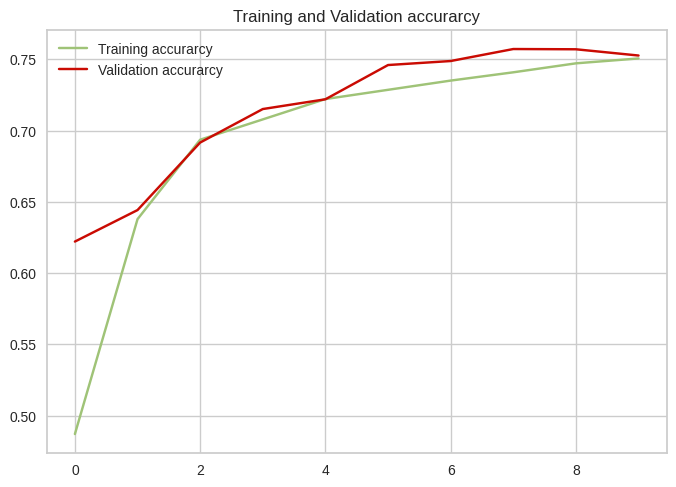

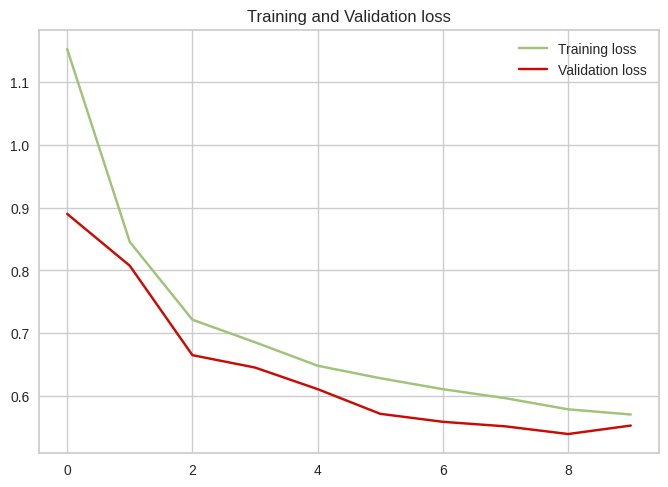

In [38]:
#Train and validation accuracy
plt.plot(history.history['accuracy'], 'g', label='Training accurarcy')
plt.plot(history.history['val_accuracy'], 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

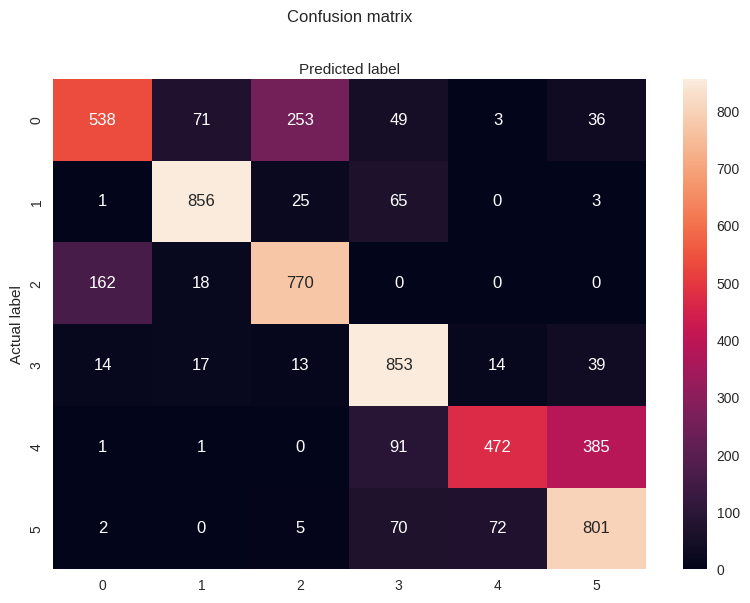

In [39]:
#confusion Matrix
matrix =confusion_matrix(y_test_new, y_pred)
class_names=[0,1,2,3,4,5]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix), annot=True, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
#Classification Report
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65       950
           1       0.89      0.90      0.89       950
           2       0.72      0.81      0.76       950
           3       0.76      0.90      0.82       950
           4       0.84      0.50      0.62       950
           5       0.63      0.84      0.72       950

    accuracy                           0.75      5700
   macro avg       0.77      0.75      0.75      5700
weighted avg       0.77      0.75      0.75      5700



GRU + BILSTM

In [41]:
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(X_train1.shape[1],1)))
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train1.shape[1],1)))
model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(cls, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 31, 256)           198912    
                                                                 
 bidirectional (Bidirection  (None, 31, 512)           1050624   
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 31, 128)           65664     
                                                                 
 flatten (Flatten)           (None, 3968)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                254016    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [42]:
history = model.fit(X_train1,y_train,batch_size=64,epochs=10,verbose=1, validation_data=(X_test1, y_test))

Epoch 1/10
802/802 [==============================] - 17s 14ms/step - loss: 0.9890 - accuracy: 0.5701 - val_loss: 0.6733 - val_accuracy: 0.7021
Epoch 2/10
802/802 [==============================] - 10s 12ms/step - loss: 0.7090 - accuracy: 0.6969 - val_loss: 0.5648 - val_accuracy: 0.7465
Epoch 3/10
802/802 [==============================] - 10s 12ms/step - loss: 0.6216 - accuracy: 0.7300 - val_loss: 0.5168 - val_accuracy: 0.7611
Epoch 4/10
802/802 [==============================] - 10s 13ms/step - loss: 0.5572 - accuracy: 0.7587 - val_loss: 0.4525 - val_accuracy: 0.8158
Epoch 5/10
802/802 [==============================] - 10s 12ms/step - loss: 0.4681 - accuracy: 0.8049 - val_loss: 0.4146 - val_accuracy: 0.8235
Epoch 6/10
802/802 [==============================] - 10s 12ms/step - loss: 0.5295 - accuracy: 0.7671 - val_loss: 0.4730 - val_accuracy: 0.7821
Epoch 7/10
802/802 [==============================] - 10s 13ms/step - loss: 0.5052 - accuracy: 0.7768 - val_loss: 0.4106 - val_accuracy:

In [43]:
pred = model.predict(X_test1)
y_pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
acc4 = accuracy_score(y_test_new,y_pred)

179/179 [==============================] - 2s 5ms/step


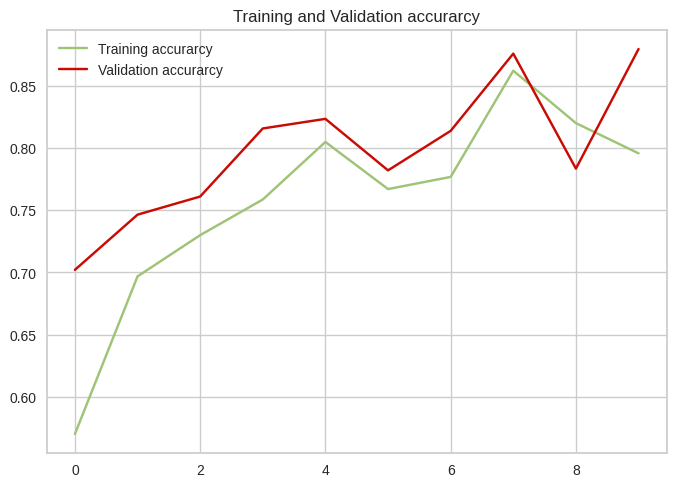

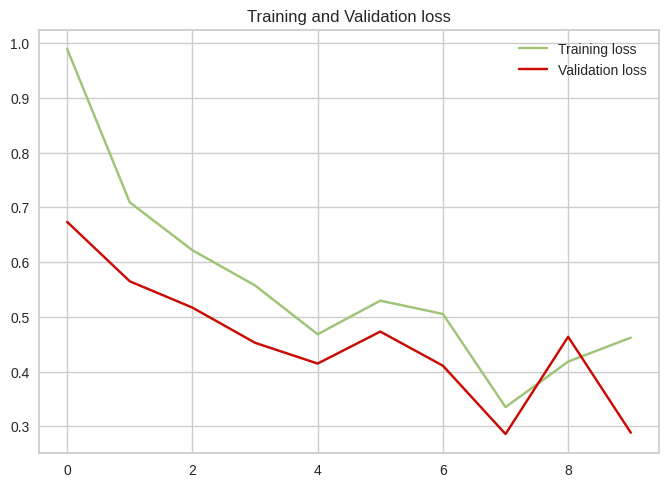

In [44]:
#Train and validation accuracy
plt.plot(history.history['accuracy'], 'g', label='Training accurarcy')
plt.plot(history.history['val_accuracy'], 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

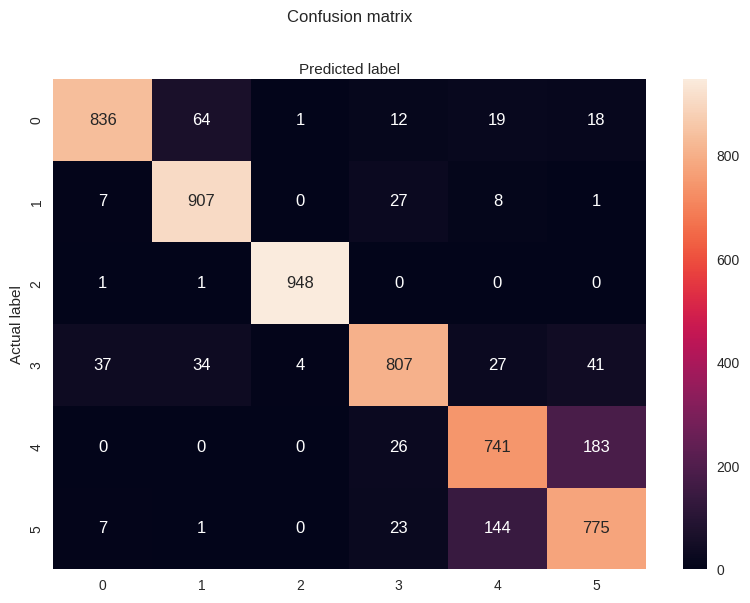

In [45]:
#confusion Matrix
matrix =confusion_matrix(y_test_new, y_pred)
class_names=[0,1,2,3,4,5]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix), annot=True, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [46]:
#Classification Report
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       950
           1       0.90      0.95      0.93       950
           2       0.99      1.00      1.00       950
           3       0.90      0.85      0.87       950
           4       0.79      0.78      0.78       950
           5       0.76      0.82      0.79       950

    accuracy                           0.88      5700
   macro avg       0.88      0.88      0.88      5700
weighted avg       0.88      0.88      0.88      5700



Accuracy Comparision Plot

<Axes: >

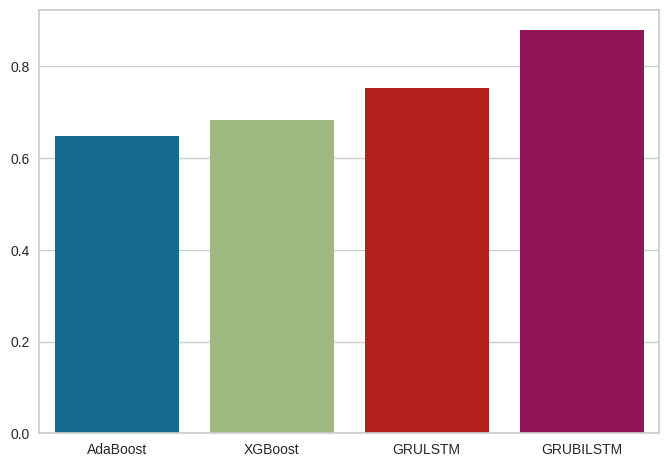

In [47]:
sns.barplot(x=['AdaBoost', 'XGBoost', 'GRULSTM', 'GRUBILSTM'], y=[acc1,acc2,acc3,acc4])